In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#load in all of the data
falling = pd.read_csv("data/falling.csv")
sitting_down= pd.read_csv("data/sitting-down.csv")
standing_up= pd.read_csv("data/standing-up.csv")
walking = pd.read_csv("data/walking2.csv")
falling.head()

,Acceleration x,Acceleration y,Acceleration z,Rotation x,Rotation y,Rotation z
0,-4.198669,-8.916077,1.907883,0.063492,-0.044830,0.001907
1,-3.940430,-8.868301,2.398254,-0.007355,-0.047882,-0.003281
2,-3.834229,-8.858749,2.288238,-0.070892,-0.020081,0.002823
3,-3.802841,-8.729813,2.501114,-0.126190,0.008011,0.008011
4,-3.942841,-8.586533,2.400650,-0.126785,0.102081,0.019623


I am worried about the standing up data, it seems to be a lot more than the sitting down data but I don't remember doing much more of it if any more at all. So I will proceed with caution in regards to it. 

In [3]:
# now split it into samples

x_train = []
y_train = []


def split_label(data, label, x_train, y_train):
    length = 679
    index = length    # this is how long a 10 second piece of data is in the file 
    while index < len(data): 
        x_train.append(data[index-length:index])
        if(label == "falling"):   
            y_train.append(1)
        elif(label =="standing-up"):
            y_train.append(0)
        elif(label =="sitting-down"):
            y_train.append(0)
        elif(label == "walking"):
            y_train.append(0)
        else:
            y_train.append(0)
        index+=length

split_label(falling, "falling", x_train, y_train)
print(len(x_train))

split_label(standing_up, "standing-up", x_train, y_train)
print(len(x_train))

split_label(sitting_down, "sitting-down", x_train, y_train)
print(len(x_train))

split_label(walking, "walking", x_train, y_train)
print(len(x_train))




    



49
157
212
235


Now we need to extract features


The features that we will extract are :

ax_var ax_mean

ay_var        ay_mean

az_var     az_mean

gx_var     gx_mean

gy_var     gy_mean

gz_var     gz_mean

a_mag_mean     g_mag_mean

a_mag_var     g_mag_var

a_max_mag

In [4]:
temp = x_train[0]
temp.head(5)

list(temp)

['Acceleration x',
 'Acceleration y',
 'Acceleration z',
 'Rotation x',
 ' Rotation y',
 ' Rotation z']

In [5]:
#data should be a dataframe object with the appropriate fields
def get_var(data):
    ax_var = np.var(data['Acceleration x'])
    ay_var = np.var(data['Acceleration y'])
    az_var = np.var(data['Acceleration z'])
    
    gx_var = np.var(data['Rotation x'])
    gy_var = np.var(data[' Rotation y'])
    gz_var = np.var(data[' Rotation z'])
    
    return ax_var, ay_var, az_var, gx_var, gy_var, gz_var 
    
def get_mean(data):
    ax_mean = np.mean(data['Acceleration x'])
    ay_mean = np.mean(data['Acceleration y'])
    az_mean = np.mean(data['Acceleration z'])
    
    gx_mean = np.mean(data['Rotation x'])
    gy_mean = np.mean(data[' Rotation y'])
    gz_mean = np.mean(data[' Rotation z'])
    
    return ax_mean, ay_mean, az_mean, gx_mean, gy_mean, gz_mean
    

def get_mag_values(data):
    x = np.square(data['Acceleration x'])
    y = np.square(data['Acceleration y'])
    z = np.square(data['Acceleration z'])
    s = x + y + z
    a_mag = np.sqrt(s)
    a_mag_mean = np.mean(a_mag)
    a_mag_var = np.var(a_mag)
    
    x = np.square(data['Rotation x'])
    y = np.square(data[' Rotation y'])
    z = np.square(data[' Rotation z'])
    s = x + y + z
    g_mag = np.sqrt(s)
    g_mag_mean = np.mean(g_mag)
    g_mag_var = np.var(g_mag)
    
    #add max magnitude
    a_max_mag = np.amax(a_mag)
    
    return a_mag_mean, a_mag_var, g_mag_mean, g_mag_var, a_max_mag



    
    
    
    
#temp = get_var(x_train[0])
#temp = get_mean(x_train[0])
#temp = get_mag_values(x_train[0])
#print(temp)

In [6]:
#now create featurized samples 

x_train_features = []
def featurize(x):
    returner = []
    for sample in x:
        temp = []
        temp += get_var(sample)
        temp += get_mean(sample)
        temp += get_mag_values(sample)
        returner.append(temp)
    return returner
x_train_features = featurize(x_train)

x_train_features = np.asarray(x_train_features)
y_train = np.asarray(y_train)

In [7]:
np.shape(x_train_features)
np.shape(y_train)


(235,)

In [50]:
#visual some shit 

indecis = list(np.arange(1,20)) + list(np.arange(212,235))
#indecis =list(np.arange(0,49))
print(indecis)
why = {}

for i in indecis:
    data = x_train[i]
    #data = 
    x = np.square(data['Acceleration x'])
    y = np.square(data['Acceleration y'])
    z = np.square(data['Acceleration z'])
    s = x + y + z
    a_mag = np.sqrt(s)
    why[i] = a_mag


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234]


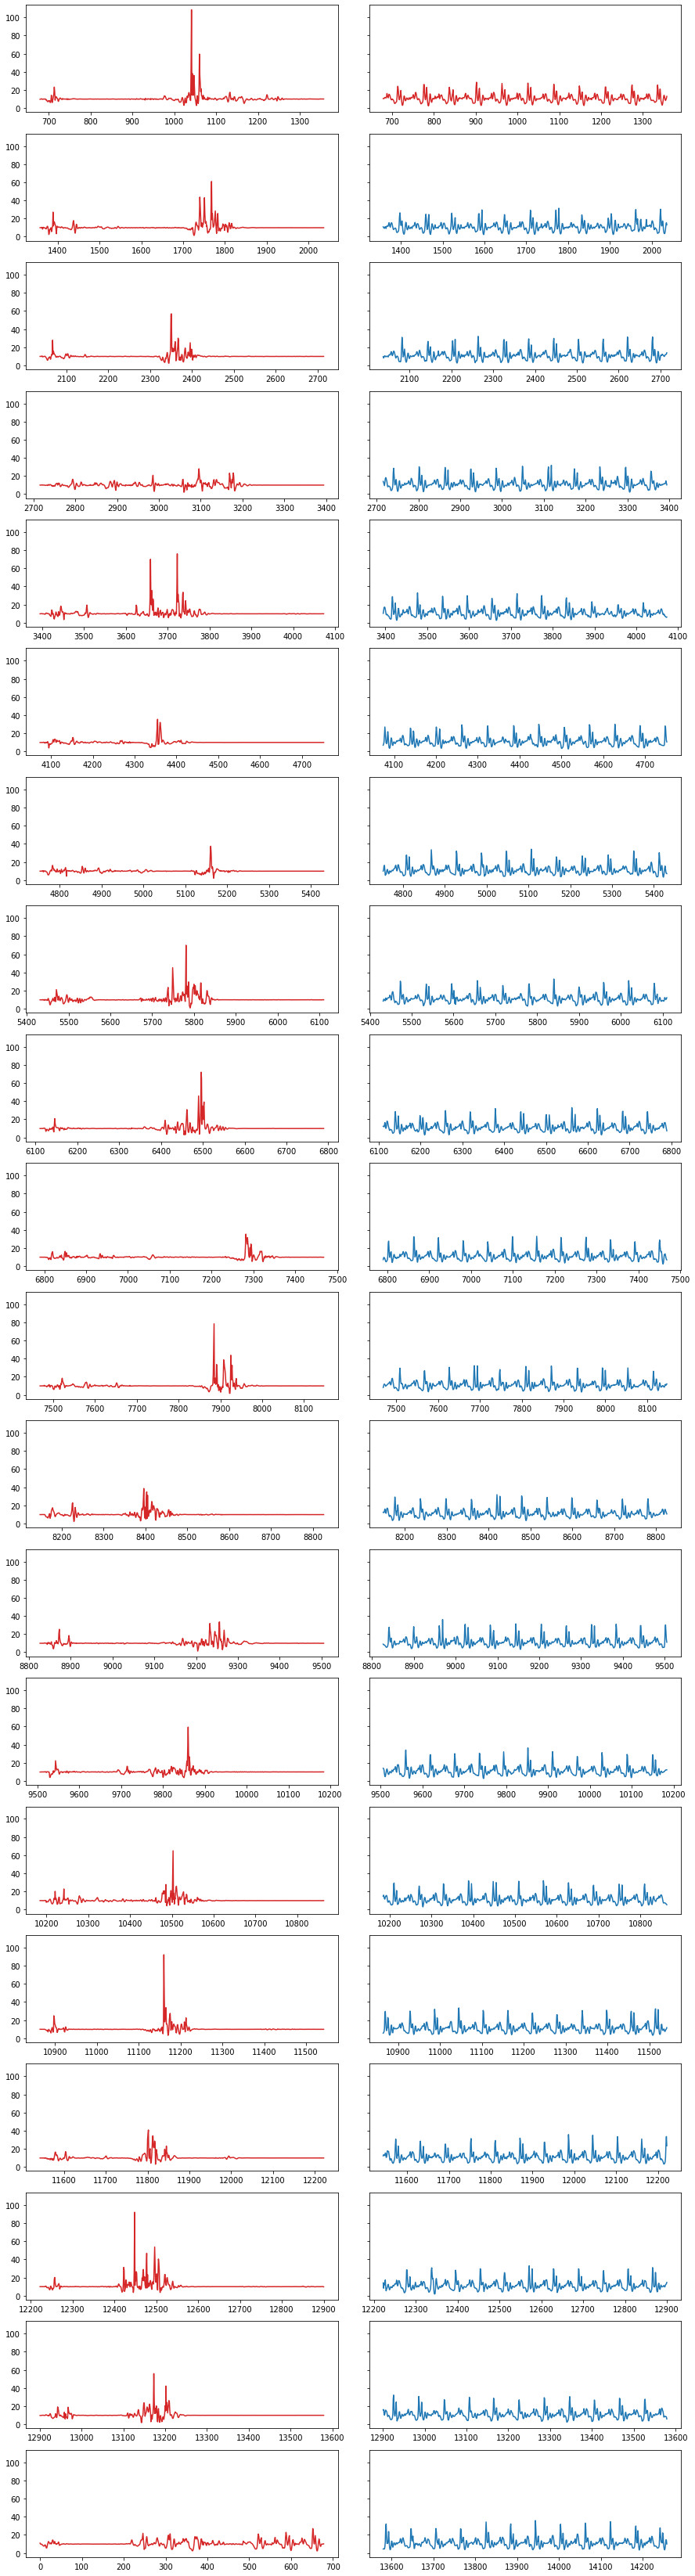

In [51]:

#m = int((49-0)/2)
m = 20
n = 2
fig, ax = plt.subplots(m, n, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
index = 0
for i in range(n):
    for j in range(m):
        if index < len(indecis)/2:
            color = 'tab:red'
        else:
            color = 'tab:blue'
        ax[j, i].plot(why[indecis[index]],color)
        index+=1
fig.set_figheight(m*3)
fig.set_figwidth(15)


#fig

In [33]:
#now lets do some 5 fold cross validation and see how we do 
#lets have max depth be 5 
max_depth = 3

n_splits = 10
kf = KFold(n_splits= n_splits, shuffle= True)

depth_scores = []

depths = [1,3,4,5,6,7,10]
for max_depth in depths: 
    scores = []
    for train_index, test_index in kf.split(x_train_features):
        tree = DecisionTreeClassifier(max_depth= max_depth, criterion= 'entropy')
        tree.fit(x_train_features[train_index],y_train[train_index])
        scores.append(tree.score(x_train_features[test_index],y_train[test_index]))
    depth_scores.append(sum(scores)/n_splits)
    
#print(sum(scores)/10)
print(depth_scores)
print(max(depth_scores))




[0.9447463768115943, 0.9702898550724637, 0.9701086956521738, 0.957608695652174, 0.9577898550724638, 0.961413043478261, 0.9577898550724637]
0.9702898550724637


In [40]:
#now lets train on the whole data set and predict on some held out data 

tree = DecisionTreeClassifier(max_depth= 3,criterion= 'entropy')
tree.fit(x_train_features,y_train)



DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [41]:
#now load in the validation data
falling_val = pd.read_csv("data2/falling.csv")
sitting_down_val= pd.read_csv("data2/sitting-down.csv")
running_val= pd.read_csv("data2/running.csv")
walking_val = pd.read_csv("data2/walking.csv")

In [42]:
#configure it correctly

x_val = []
y_val = []

split_label(falling_val, "falling", x_val, y_val)
print(len(x_val))
split_label(sitting_down_val,"sitting-down",x_val,y_val)
print(len(x_val))
#split_label(running_val, "running", x_val, y_val)
#print(len(x_val))
split_label(walking_val, "walking", x_val, y_val)
print(len(x_val))

#featurize
x_val = featurize(x_val)

#make it np arrays
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

57
82
105


In [43]:
tree.score(x_val,y_val)
#tree.score(x_val,y_val)


0.8285714285714286

In [44]:
from sklearn.tree._tree import TREE_LEAF
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

feature_names = [
    "ax_var",
    "ax_mean",
    "ay_var",
    "ay_mean",
    "az_var",
    "az_mean",
    "gx_var",
    "gx_mean",
    "gy_var",
    "gy_mean",
    "gz_var",
    "gz_mean",
    "a_mag_mean",
    "g_mag_mean",
    "a_mag_var",
    "g_mag_var",
    "a_max_mag"
]

def print_decision_tree(model):
    # Taken from https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
    dot_data = StringIO()

    export_graphviz(model, out_file=dot_data,   
                    feature_names = feature_names,
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

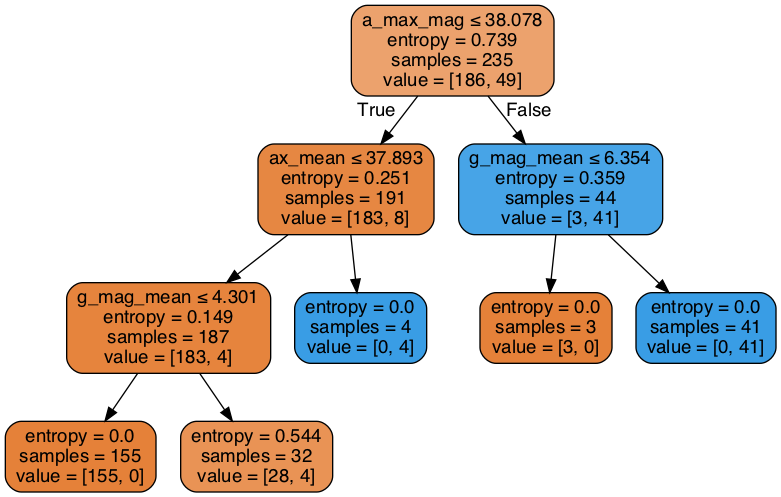

In [45]:
print_decision_tree(tree)

In [17]:
knn = KNeighborsClassifier(n_neighbors= 1)
knn.fit(x_val, y_val)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [18]:
knn.score(x_train_features, y_train)

0.6297872340425532